# Feature Engineering

## Welcome to Feature Engineering!
In this course you'll learn about one of the most important steps on the way to building a great machine learning model: feature engineering. You'll learn how to:

+ determine which features are the most important with mutual information
+ invent new features in several real-world problem domains
+ encode high-cardinality categoricals with a target encoding
+ create segmentation features with k-means clustering
+ decompose a dataset's variation into features with principal component analysis

## The Goal of Feature Engineering

You might perform feature engineering to:

+ improve a model's predictive performance
+ reduce computational or data needs
+ improve interpretability of the results

The Concrete dataset contains a variety of concrete formulations and the resulting product's compressive strength, which is a measure of how much load that kind of concrete can bear. The task for this dataset is to predict a concrete's compressive strength given its formulation.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("../../dataset/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


You can see here the various ingredients going into each variety of concrete. We'll see in a moment how adding some additional synthetic features derived from these can help a model to learn important relationships among them.

We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [2]:
X = df.copy() # Create a copy of the data
y = X.pop("CompressiveStrength") # Remove the target variable from the data

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0) # Create the baseline model
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error" # Score the baseline model
)
baseline_score = -1 * baseline_score.mean() # Calculate the mean of the cross-validated scores

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


If you ever cook at home, you might know that the ratio of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of CompressiveStrength.

The cell below adds three new ratio features to the dataset.

In [3]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"] # Fine to Coarse aggregate ratio
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"] # Aggregate to Cement ratio
X["WtrCmtRatio"] = X["Water"] / X["Cement"] # Water to Cement ratio

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


# Mutual Information

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet.
 
It is:

+ easy to use and interpret
+ computationally efficient
+ theoretically well-founded
+ resistant to overfitting
+ able to detect any kind of relationship

## Interpreting Mutual Information Scores

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

The next figure will give you an idea of how MI values correspond to the kind and degree of association a feature has with the target.

### Here are some things to remember when applying mutual information:

MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

## Example - 1985 Automobiles

The Automobile dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's price (the target) from 23 of the car's features, such as make, body_style, and horsepower. In this example, we'll rank the features with mutual information and investigate the results by data visualization.

This hidden cell imports some libraries and loads the dataset.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


df = pd.read_csv("../../dataset/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding.

In [7]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [8]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
print(mi_scores[::3])  # show a few features with their MI scores

curb_weight          1.526360
highway_mpg          0.958830
length               0.603724
bore                 0.499503
stroke               0.384121
num_of_cylinders     0.331337
compression_ratio    0.133132
fuel_type            0.047298
Name: MI Scores, dtype: float64


And now a bar plot to make comparisions easier:

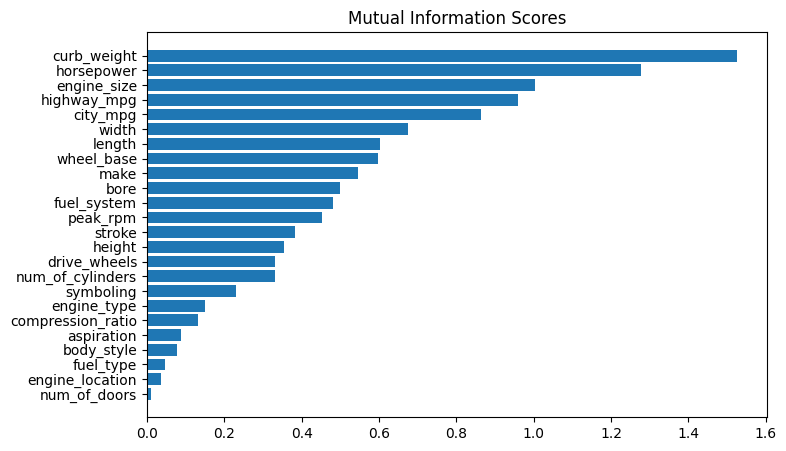

In [9]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring curb_weight feature exhibits a strong relationship with price, the target.

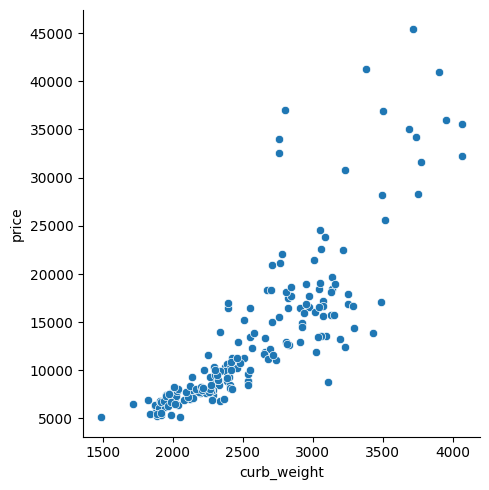

In [10]:
sns.relplot(x="curb_weight", y="price", data=df);

The fuel_type feature has a fairly low MI score, but as we can see from the figure, it clearly separates two price populations with different trends within the horsepower feature. This indicates that fuel_type contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

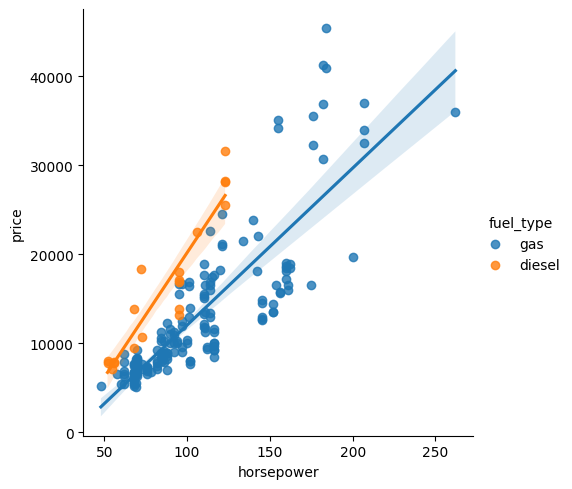

In [11]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

## Creating Features

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

accidents = pd.read_csv("../../dataset/accidents.csv.zip")
autos = pd.read_csv("../../dataset/autos.csv")
concrete = pd.read_csv("../../dataset/concrete.csv")
customer = pd.read_csv("../../dataset/customer.csv.zip")

## Tips on Discovering New Features

1. Understand the features. Refer to your dataset's data documentation, if available.
2. Research the problem domain to acquire domain knowledge. If your problem is predicting house prices, do some research on real-estate for instance. Wikipedia can be a good starting point, but books and journal articles will often have the best information.
3. Study previous work. Solution write-ups from past Kaggle competitions are a great resource.
4. Use data visualization. Visualization can reveal pathologies in the distribution of a feature or complicated relationships that could be simplified. Be sure to visualize your dataset as you work through the feature engineering process.

## Mathematical Transforms
Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In the Automobile dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [2]:
autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it will be for a model to learn, like this formula for an engine's "displacement", a measure of its power:

In [3]:
autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)
autos[["displacement", "bore", "num_of_cylinders"]].head()

,displacement,bore,num_of_cylinders
0,101.377976,3.47,4
1,101.377976,3.47,4
2,117.446531,2.68,6
3,108.695147,3.19,4
4,135.868934,3.19,5


Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of WindSpeed in US Accidents is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

<Axes: xlabel='LogWindSpeed', ylabel='Density'>

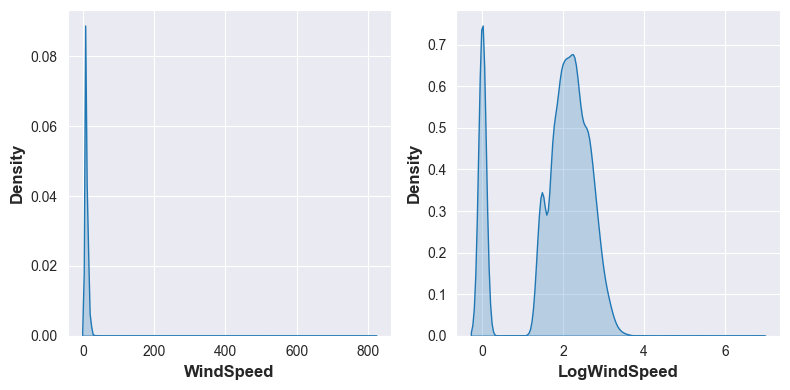

In [5]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, fill=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, fill=True, ax=axs[1])

## Counts

Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a count.

These features will be binary (1 for Present, 0 for Absent) or boolean (True or False). In Python, booleans can be added up just as if they were integers.

In Traffic Accidents are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the sum method:

In [6]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


You could also use a dataframe's built-in methods to create boolean values. In the Concrete dataset are the amounts of components in a concrete formulation. Many formulations lack one or more components (that is, the component has a value of 0). This will count how many components are in a formulation with the dataframe's built-in greater-than gt method:

In [7]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1) # Count the number of components in each formulation ( where gt(0) - greater than 0)
# in row where some of features are 0, it will be summered at total count of components
# for example, if Cement, BlastFurnaceSlag, FlyAsh, Water are 0, then it will be 4

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


## Building-Up and Breaking-Down Features

Often you'll have complex strings that can usefully be broken into simpler pieces. Some common examples:

+ ID numbers: '123-45-6789'
+ Phone numbers: '(999) 555-0123'
+ Street addresses: '8241 Kaggle Ln., Goose City, NV'
+ Internet addresses: 'http://www.kaggle.com
+ Product codes: '0 36000 29145 2'
+ Dates and times: 'Mon Sep 30 07:06:05 2013'

Features like these will often have some kind of structure that you can make use of. US phone numbers, for instance, have an area code (the '(999)' part) that tells you the location of the caller. As always, some research can pay off here.

The str accessor lets you apply string methods like split directly to columns. The Customer Lifetime Value dataset contains features describing customers of an insurance company. From the Policy feature, we could separate the Type from the Level of coverage:

In [8]:
customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


You could also join simple features into a composed feature if you had reason to believe there was some interaction in the combination:

In [9]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


## Group Transforms

Finally, we have Group transforms, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average 
income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that category could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. 
For an "average income by state", you would choose State for the grouping feature, mean for the aggregation function, and Income for the aggregated feature. To compute this in Pandas, we use the group_by and transform methods:

In [10]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


The mean function is a built-in dataframe method, which means we can pass it as a string to transform. Other handy methods include max, min, median, var, std, and count. Here's how you could calculate the frequency with which each state occurs in the dataset:

In [11]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


You could use a transform like this to create a "frequency encoding" for a categorical feature.

If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's merge method after creating a unique set of values with drop_duplicates on the training set:

In [12]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Extended,485.326930
1,Basic,385.606423
2,Basic,385.606423
3,Basic,385.606423
4,Basic,385.606423
5,Premium,643.405305
6,Basic,385.606423
7,Basic,385.606423
8,Basic,385.606423
9,Basic,385.606423


## Tips on Creating Features

It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

+ Linear models learn sums and differences naturally, but can't learn anything more complex.
+ Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
+ Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
+ Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
+ Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


# Prepare data
df = pd.read_csv("../input/fe-course-data/ames.csv")
X = df.copy()
y = X.pop("SalePrice")

Create Mathematical Transforms
Create the following features:

LivLotRatio: the ratio of GrLivArea to LotArea
Spaciousness: the sum of FirstFlrSF and SecondFlrSF divided by TotRmsAbvGrd
TotalOutsideSF: the sum of WoodDeckSF, OpenPorchSF, EnclosedPorch, Threeseasonporch, and ScreenPorch

In [ ]:
X_1 = pd.DataFrame()  # dataframe to hold new features

X_1["LivLotRatio"] = X["GrLivArea"]/X["LotArea"]
X_1["Spaciousness"] = (X["FirstFlrSF"]+X["SecondFlrSF"])/X["TotRmsAbvGrd"] 
X_1["TotalOutsideSF"] = X["WoodDeckSF"] + X["OpenPorchSF"] + X["EnclosedPorch"] + X["Threeseasonporch"] + X["ScreenPorch"]

## Interaction with a Categorical
We discovered an interaction between BldgType and GrLivArea in Exercise 2. Now create their interaction features.

In [13]:
# One-hot encode BldgType. Use `prefix="Bldg"` in `get_dummies`
X_2 = pd.get_dummies(df.BldgType, prefix="Bldg") 
# Multiply
X_2 = X_2.mul(df.GrLivArea, axis=0)
X_2.head(10)

NameError: name 'df' is not defined

## Count Feature

Let's try creating a feature that describes how many kinds of outdoor areas a dwelling has. Create a feature PorchTypes that counts how many of the following are greater than 0.0:

WoodDeckSF
OpenPorchSF
EnclosedPorch
Threeseasonporch
ScreenPorch

In [ ]:
X_3 = pd.DataFrame()

# YOUR CODE HERE
columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch']
X_3["PorchTypes"] = df[columns].gt(0).sum(axis=1)

You can see that there is a more general categorization described (roughly) by the first word of each category. Create a feature containing only these first words by splitting MSSubClass at the first underscore _. (Hint: In the split method use an argument n=1.)

In [ ]:
X_4 = pd.DataFrame()

# YOUR CODE HERE
X_4["MSClass"] = df["MSSubClass"].str.split('_', n=1, expand=True)[0]

 ### Use a Grouped Transform
 
The value of a home often depends on how it compares to typical homes in its neighborhood. Create a feature MedNhbdArea that describes the median of GrLivArea grouped on Neighborhood.

In [ ]:
X_5 = pd.DataFrame()

# YOUR CODE HERE
X_5["MedNhbdArea"] = df.groupby('Neighborhood')['GrLivArea'].transform('median')